In [31]:
import os
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read Dataset

In [32]:
dataset_root = 'datasets/Gesture/'
csv_path = os.path.join(dataset_root, 'keypoints.csv')

df = pd.read_csv(csv_path)
df.head()

,image_name,label,wrist_x,wrist_y,thumb_mcp_x,thumb_mcp_y,thumb_tip_x,thumb_tip_y,index_finger_pip_x,index_finger_pip_y,...,middle_finger_tip_x,middle_finger_tip_y,ring_finger_pip_x,ring_finger_pip_y,ring_finger_tip_x,ring_finger_tip_y,pinky_finger_pip_x,pinky_finger_pip_y,pinky_finger_tip_x,pinky_finger_tip_y
0,d_692.jpg,d,0.618151,0.876113,0.705054,0.615049,0.422460,0.450940,0.631901,0.277557,...,0.549780,0.543019,0.385581,0.501556,0.526133,0.623931,0.361523,0.623654,0.489014,0.710604
1,d_420.jpg,d,0.411787,0.819458,0.466265,0.599594,0.376716,0.498577,0.417343,0.384985,...,0.405332,0.596215,0.349775,0.520015,0.375494,0.640230,0.320038,0.575412,0.340712,0.658984
2,d_840.jpg,d,0.460546,0.912746,0.604421,0.735319,0.469869,0.609714,0.607432,0.367080,...,0.480922,0.579544,0.357676,0.487423,0.410179,0.624444,0.282997,0.583172,0.348465,0.650387
3,d_1483.jpg,d,0.612783,0.973389,0.651738,0.690360,0.473596,0.561144,0.623126,0.476593,...,0.544173,0.646420,0.424313,0.612456,0.517804,0.724607,0.387420,0.676069,0.471215,0.761102
4,d_798.jpg,d,0.559466,1.039490,0.714575,0.826325,0.553946,0.656391,0.605815,0.397054,...,0.590521,0.682558,0.472580,0.607049,0.531682,0.783548,0.404718,0.682563,0.457287,0.793659


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image_name           4282 non-null   object 
 1   label                4282 non-null   object 
 2   wrist_x              4282 non-null   float64
 3   wrist_y              4282 non-null   float64
 4   thumb_mcp_x          4282 non-null   float64
 5   thumb_mcp_y          4282 non-null   float64
 6   thumb_tip_x          4282 non-null   float64
 7   thumb_tip_y          4282 non-null   float64
 8   index_finger_pip_x   4282 non-null   float64
 9   index_finger_pip_y   4282 non-null   float64
 10  index_finger_tip_x   4282 non-null   float64
 11  index_finger_tip_y   4282 non-null   float64
 12  middle_finger_pip_x  4282 non-null   float64
 13  middle_finger_pip_y  4282 non-null   float64
 14  middle_finger_tip_x  4282 non-null   float64
 15  middle_finger_tip_y  4282 non-null   f

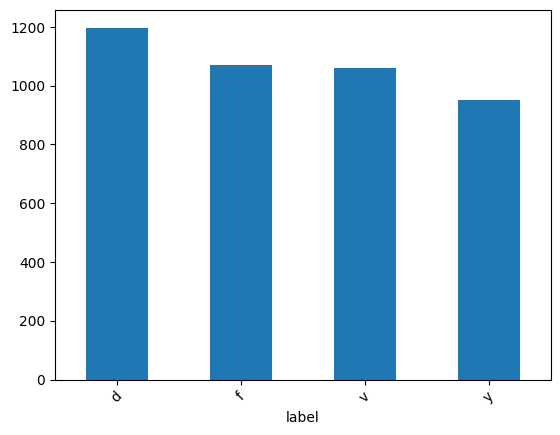

In [34]:
df.label.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [35]:
# Encoder label
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([0, 0, 0, ..., 2, 2, 2])

In [36]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([0.89357262, 0.99953315, 1.00800377, 1.1256572 ])

In [37]:
# Get keypoint dataset
x = df.iloc[:, 2:]
x

,wrist_x,wrist_y,thumb_mcp_x,thumb_mcp_y,thumb_tip_x,thumb_tip_y,index_finger_pip_x,index_finger_pip_y,index_finger_tip_x,index_finger_tip_y,...,middle_finger_tip_x,middle_finger_tip_y,ring_finger_pip_x,ring_finger_pip_y,ring_finger_tip_x,ring_finger_tip_y,pinky_finger_pip_x,pinky_finger_pip_y,pinky_finger_tip_x,pinky_finger_tip_y
0,0.618151,0.876113,0.705054,0.615049,0.422460,0.450940,0.631901,0.277557,0.594324,0.062254,...,0.549780,0.543019,0.385581,0.501556,0.526133,0.623931,0.361523,0.623654,0.489014,0.710604
1,0.411787,0.819458,0.466265,0.599594,0.376716,0.498577,0.417343,0.384985,0.404069,0.222071,...,0.405332,0.596215,0.349775,0.520015,0.375494,0.640230,0.320038,0.575412,0.340712,0.658984
2,0.460546,0.912746,0.604421,0.735319,0.469869,0.609714,0.607432,0.367080,0.628248,0.172647,...,0.480922,0.579544,0.357676,0.487423,0.410179,0.624444,0.282997,0.583172,0.348465,0.650387
3,0.612783,0.973389,0.651738,0.690360,0.473596,0.561144,0.623126,0.476593,0.621020,0.347756,...,0.544173,0.646420,0.424313,0.612456,0.517804,0.724607,0.387420,0.676069,0.471215,0.761102
4,0.559466,1.039490,0.714575,0.826325,0.553946,0.656391,0.605815,0.397054,0.608796,0.188752,...,0.590521,0.682558,0.472580,0.607049,0.531682,0.783548,0.404718,0.682563,0.457287,0.793659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0.521778,0.853480,0.578815,0.637091,0.483573,0.532677,0.537044,0.486486,0.560060,0.593087,...,0.524161,0.610371,0.457601,0.516627,0.492502,0.632411,0.435745,0.587399,0.464875,0.667675
4278,0.398655,0.890068,0.438849,0.658474,0.332103,0.561582,0.428466,0.451733,0.418910,0.284694,...,0.376408,0.291176,0.325057,0.553944,0.364484,0.665717,0.295471,0.618903,0.330594,0.696439
4279,0.635133,0.919650,0.775299,0.771324,0.500660,0.619432,0.448809,0.425972,0.344815,0.224029,...,0.484241,0.766736,0.206712,0.631304,0.539737,0.834684,0.209915,0.714357,0.482284,0.858713
4280,0.421138,0.974637,0.464192,0.737854,0.162269,0.649324,0.381438,0.422469,0.340262,0.235110,...,0.056569,0.208142,0.112191,0.556358,0.247927,0.711120,0.039116,0.608706,0.155993,0.713388


In [38]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True, random_state=2024)

print('Number of Training keypoints: ', len(x_train))
print('Number of Testing keypoints: ', len(x_test))

Number of Training keypoints:  3425
Number of Testing keypoints:  857


In [39]:
min = np.array(np.min(x_train, axis=0))
max = np.array(np.max(x_train, axis=0))
scaler_minmax_path = 'models/scaler_minmax.npy'
np.save(scaler_minmax_path, np.array([min, max]))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Data Loader

In [40]:
class DataKeypoint(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [41]:
train_dataset = DataKeypoint(x_train, y_train)
test_dataset = DataKeypoint(x_test, y_test)

In [42]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [43]:
from utils.classifier import Network

hidden_size = 128
model = Network(x_train.shape[1], hidden_size, len(class_weights))
len(class_weights)

4

## Loss & Optimizer

In [44]:
num_epoch = 50
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [45]:
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch [{epoch}/{num_epoch}]')
        loop.set_postfix(loss=loss.item(), acc=accuracy)


Epoch [49/50]: 100%|██████████| 27/27 [00:00<00:00, 300.98it/s, acc=0.742, loss=0.0583]


## Test

In [46]:
test_features = torch.from_numpy(x_test.astype(np.float32))
test_labels = y_test

with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
    
predictions

tensor([3, 2, 3, 0, 1, 1, 3, 2, 0, 1, 0, 0, 3, 3, 0, 0, 0, 1, 3, 1, 1, 3, 2, 0,
        1, 2, 0, 1, 3, 0, 1, 0, 1, 1, 3, 1, 0, 1, 3, 1, 2, 0, 1, 0, 2, 2, 3, 0,
        1, 3, 1, 3, 2, 3, 2, 2, 3, 0, 2, 1, 1, 3, 2, 2, 1, 0, 3, 0, 1, 3, 2, 2,
        2, 1, 1, 1, 3, 3, 1, 1, 2, 3, 0, 0, 1, 1, 2, 1, 3, 0, 3, 1, 0, 2, 0, 1,
        0, 2, 3, 3, 3, 0, 2, 0, 3, 1, 3, 2, 0, 1, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1,
        3, 2, 2, 2, 0, 1, 0, 0, 1, 1, 3, 2, 0, 0, 3, 0, 0, 0, 2, 1, 0, 2, 1, 0,
        0, 0, 0, 3, 2, 2, 3, 2, 1, 2, 1, 3, 3, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2,
        0, 1, 2, 3, 2, 2, 1, 2, 0, 0, 3, 3, 2, 0, 2, 3, 2, 0, 3, 1, 1, 0, 1, 1,
        0, 1, 1, 2, 1, 1, 1, 3, 3, 3, 0, 0, 2, 3, 2, 3, 3, 0, 3, 2, 3, 0, 3, 2,
        3, 2, 0, 0, 2, 3, 1, 2, 0, 2, 3, 1, 3, 0, 0, 1, 1, 0, 2, 2, 1, 3, 2, 1,
        2, 3, 2, 2, 3, 2, 2, 3, 0, 1, 0, 0, 1, 3, 0, 0, 2, 3, 1, 0, 1, 1, 0, 1,
        0, 2, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 3, 0, 2, 3, 1, 0, 3, 2, 1, 3, 0, 2,
        0, 3, 3, 2, 2, 3, 0, 2, 2, 2, 2,

In [47]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

           d       0.97      0.95      0.96       240
           f       0.99      0.99      0.99       214
           v       0.93      0.95      0.94       213
           y       0.98      0.98      0.98       190

    accuracy                           0.97       857
   macro avg       0.97      0.97      0.97       857
weighted avg       0.97      0.97      0.97       857



In [48]:
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
df_cm

,d,f,v,y
d,228,1,9,2
f,0,211,3,0
v,8,1,203,1
y,0,0,3,187


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


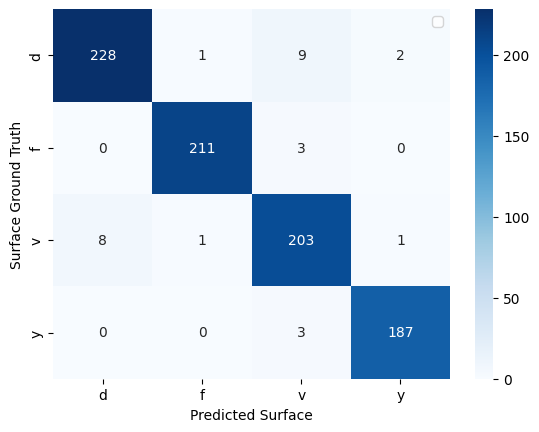

In [50]:
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Surface Ground Truth')
    plt.xlabel('Predicted Surface')
    plt.legend()
    
show_confusion_matrix(df_cm)

## save model

In [51]:
save_path = 'models/classification.pt'
torch.save(model.state_dict(), save_path)